In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta

In [2]:
# importing historical data from 2008 to 2021
SPY_Data = pd.read_csv('SPY_1min_data.csv', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Parse datetime column and divide in 2 columns
# SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
SPY_Data.rename(columns={
    'date': 'datetime'
}, inplace=True)

SPY_Data['datetime'] = pd.to_datetime(SPY_Data['datetime'])

SPY_Data['Date'] = SPY_Data['datetime'].dt.date
SPY_Data['Time'] = SPY_Data['datetime'].dt.time

# sorting the data by the time column to make sure it is consistent
SPY_Data.sort_values('datetime', inplace=True)

# Drop original 'date' column
# SPY_Data.drop(columns=['date'], inplace=True)

# Filter for regular trading hours using datetime column
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time >= pd.to_datetime("09:30").time()]
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time <= pd.to_datetime("16:00").time()]

# Making sure the order of the columns stays the same 
SPY_Data = SPY_Data[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [3]:
# ---- Parameters you can tweak ----
OPEN_START = "09:30:00"
OPEN_END_EXCLUSIVE = "09:35:00"   # 5-min opening range is 09:30:00–09:34:59
SESSION_END = "16:00:00"
retest_tolerance = 0.01           # how close is "touch" of boundary ($0.01)
use_close_for_breakout = True     # breakout defined by candle close beyond boundary (else use high/low pierce)
one_setup_per_day = True          # take first valid setup only per day
slippage = 0.00                   # optional per-share slippage
# ----------------------------------

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("09:35").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("09:35").time()]

    for _, row in intraday.iterrows():
        if row['high'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['low'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


breaches = []
for d in SPY_Data['Date'].unique():
    b = get_first_breach(SPY_Data, d)
    if b:
        breaches.append(b)

breach_df = pd.DataFrame(breaches)
breach_df




,Date,timeBreach,breach,OR_high,OR_low
0,2019-12-31,09:35:00,high,321.05,320.15
1,2020-01-02,09:35:00,high,323.86,323.41
2,2020-01-03,09:43:00,high,322.66,321.10
3,2020-01-06,09:36:00,high,321.23,320.36
4,2020-01-07,09:35:00,high,323.17,322.69
...,...,...,...,...,...
1397,2025-07-28,09:40:00,low,637.84,637.31
1398,2025-07-29,09:43:00,low,638.67,638.01
1399,2025-07-30,09:37:00,high,636.03,635.29
1400,2025-07-31,09:39:00,low,639.75,638.40


In [4]:
def get_first_retest(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= high_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= low_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
    return None


retests = []
for d in SPY_Data['Date'].unique():
    b = get_first_retest(SPY_Data, d, breach_df)
    if b:
        retests.append(b)

retests_df = pd.DataFrame(retests)
retests_df



,Date,timeBreach,breach,OR_high,OR_low,timeRetest
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00
...,...,...,...,...,...,...
1168,2025-07-28,09:40:00,low,637.84,637.31,09:51:00
1169,2025-07-29,09:43:00,low,638.67,638.01,09:57:00
1170,2025-07-30,09:37:00,high,636.03,635.29,09:47:00
1171,2025-07-31,09:39:00,low,639.75,638.40,09:45:00


In [5]:
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeRetest = retestInfo['timeRetest'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeRetest)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
    return None


confirmationBars = []
for d in retests_df['Date'].unique():
    b = detectConfirmation(SPY_Data, d, retests_df)
    if b:
        confirmationBars.append(b)

confirmationBar_df = pd.DataFrame(confirmationBars)
confirmationBar_df

# the 12th of november has a failed outbreak to the high but it does the right pattern later in the low

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00,10:09:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00,15:22:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00,09:58:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00,11:35:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00,09:49:00
...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00


In [6]:
import pandas as pd

def runBacktest(data_df, date, confirmationBar_df, exit_mode="stop", slippage=0.01):
    """
    Backtest function with configurable exit logic and slippage.

    exit_mode options:
    - "stop"       : Exit at stopLoss price when breached (worst-case intrabar fill).
    - "next_open"  : Exit at next bar's open after breach (no intrabar lookahead).
    - "hybrid"     : Exit at stopLoss if touched, else at next bar's open.

    slippage:
    - Applied against you on exit.
    - Longs: exitPrice -= slippage
    - Shorts: exitPrice += slippage
    """
    if str(date) == '2024-11-05':
        print('')
    
    
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]

    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    entryPrice = intraday.iloc[0]['open']
    
    # initial stop
    if typeBreach == 'high':   # long
        # stopLoss = high_or - ((high_or - low_or) * 0.15)
        stopLoss = high_or
    else:   # short
        # stopLoss = low_or + ((high_or - low_or) * 0.15)
        stopLoss = low_or

    # buffer = fraction of initial risk
    initialRisk = abs(entryPrice - stopLoss)
    buffer = initialRisk

    # loop intraday
    for i in range(len(intraday) - 1):  
        row = intraday.iloc[i]
        next_row = intraday.iloc[i+1]

        if typeBreach == 'high':  # long trade
            if row['close'] >= stopLoss + buffer:
                stopLoss = row['close'] - buffer

            if row['close'] <= stopLoss:  # stop triggered
                if exit_mode == "stop":
                    exitPrice, exitTime = stopLoss, row['Time']
                elif exit_mode == "next_open":
                    exitPrice, exitTime = next_row['open'], next_row['Time']
                elif exit_mode == "hybrid":
                    exitPrice, exitTime = stopLoss, row['Time']
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice
                }

        else:  # short trade
            if row['close'] <= stopLoss - buffer:
                stopLoss = row['close'] + buffer

            if row['close'] >= stopLoss:  # stop triggered
                if exit_mode == "stop":
                    exitPrice, exitTime = stopLoss, row['Time']
                elif exit_mode == "next_open":
                    exitPrice, exitTime = next_row['open'], next_row['Time']
                elif exit_mode == "hybrid":
                    exitPrice, exitTime = stopLoss, row['Time']
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice
                }

    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit -= slippage
    else:
        finalExit += slippage

    return {
        'Date': date,
        'timeBreach': signalInfo['timeBreach'].iloc[0],
        'breach': typeBreach,
        'OR_high': high_or,
        'OR_low': low_or,
        'timeRetest': timeRetest,
        'timeConfirmationBar': timeConfirmationBar,
        'timeExit': finalExitTime,
        'entryPrice': entryPrice,
        'exitPrice': finalExit,
        'returns': finalExit - entryPrice if typeBreach == 'high' else entryPrice - finalExit
    }




# Run backtest
backtest = []
for d in confirmationBar_df['Date'].unique():
    b = runBacktest(SPY_Data, d, confirmationBar_df)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


Total PnL: 73.72000000000997


,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00,10:09:00,10:13:00,321.13,321.04,-9.000000e-02
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00,15:22:00,15:36:00,323.92,323.99,7.000000e-02
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00,09:58:00,10:00:00,322.86,322.65,-2.100000e-01
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00,11:35:00,11:37:00,323.20,323.20,5.684342e-14
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00,09:49:00,09:50:00,323.54,323.44,-1.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00,09:58:00,637.18,637.32,-1.400000e-01
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00,10:05:00,637.92,637.79,1.300000e-01
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00,10:49:00,636.32,636.42,1.000000e-01
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00,09:48:00,637.95,638.41,-4.600000e-01


n_trades                1061.000000
win_rate                   0.408106
avg_win                    0.530554
avg_loss                  -0.250417
payoff_ratio               2.118680
expectancy_per_trade       0.069482
gross_profit             229.730000
gross_loss               156.010000
profit_factor              1.472534
total_pnl                 73.720000
median_pnl                -0.060000
max_drawdown             -12.850000
sharpe_per_trade           1.634834
dtype: float64


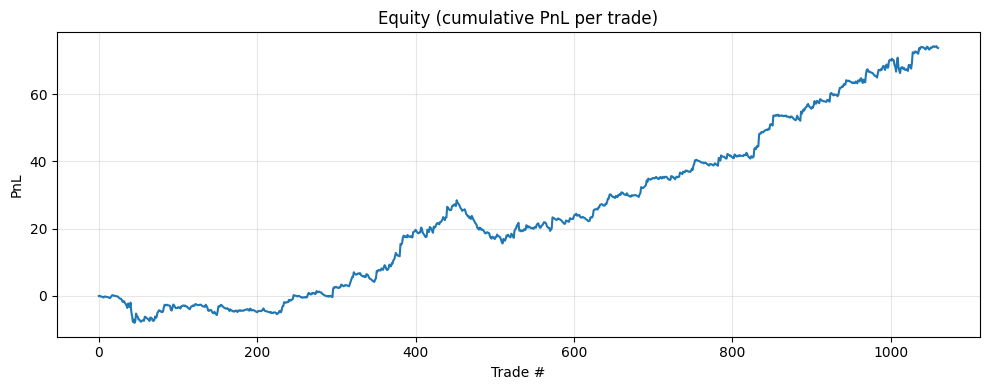

In [7]:
import numpy as np
import pandas as pd

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / n)
    loss_rate = float(len(losses) / n)

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats, equity, drawdown

stats, equity, dd = trade_stats(backtest_df, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


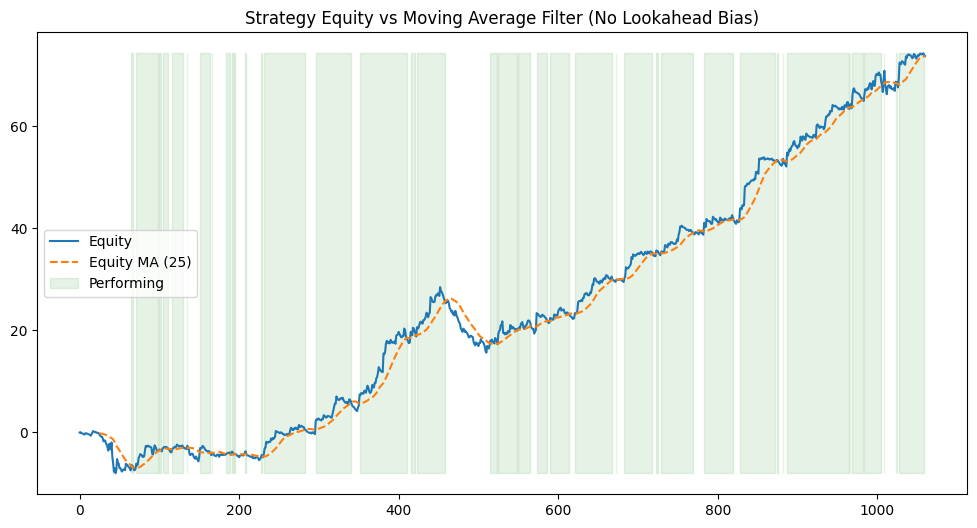

In [8]:
test_df = backtest_df.copy(deep=True)

# Equity curve
test_df['equity'] = test_df['returns'].cumsum()

# Moving average of equity (use only past info)
window = 25
test_df['equity_ma'] = test_df['equity'].rolling(window).mean().shift(1)
test_df['is_performing'] = test_df['equity'] > test_df['equity_ma']

# Rolling Sharpe (lookback window, shifted)
def rolling_sharpe(series, window=50):
    roll_mean = series.rolling(window).mean()
    roll_std = series.rolling(window).std() + 1e-8
    return (roll_mean / roll_std).shift(1)

test_df['rolling_sharpe'] = rolling_sharpe(test_df['returns'], 50)
# test_df['is_performing'] = test_df['rolling_sharpe'] > 0

# Rolling winrate (shifted)
test_df['rolling_winrate'] = (test_df['returns'] > 0).rolling(50).mean().shift(1)
# test_df['is_performing'] = test_df['rolling_winrate'] > 0.5

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_df['equity'], label='Equity')
plt.plot(test_df['equity_ma'], label='Equity MA (25)', linestyle='--')
plt.fill_between(
    test_df.index,
    test_df['equity'].min(),
    test_df['equity'].max(),
    where=test_df['is_performing'],
    color='green', alpha=0.1, label='Performing'
)
plt.legend()
plt.title("Strategy Equity vs Moving Average Filter (No Lookahead Bias)")
plt.show()


In [9]:
test_df = test_df[test_df['is_performing'] == True].copy(deep=True)
test_df['equity'] = test_df['returns'].cumsum()
test_df

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns,equity,equity_ma,is_performing,rolling_sharpe,rolling_winrate
65,2020-04-23,09:35:00,high,281.76,280.15,09:46:00,10:19:00,10:51:00,282.25,283.28,1.03,1.03,-6.7040,True,-0.181334,0.28
66,2020-04-24,09:36:00,low,281.29,280.32,10:38:00,10:41:00,10:45:00,280.15,280.24,-0.09,0.94,-6.8812,True,-0.159102,0.28
67,2020-04-27,09:35:00,high,285.45,284.81,10:00:00,10:02:00,10:05:00,285.68,285.45,-0.23,0.71,-6.9516,True,-0.169554,0.26
71,2020-05-06,09:39:00,low,288.46,287.72,09:47:00,09:48:00,09:59:00,287.39,286.37,1.02,1.73,-6.9444,True,-0.189115,0.24
72,2020-05-07,09:36:00,high,288.45,287.65,09:44:00,09:55:00,10:02:00,288.89,288.47,-0.42,1.31,-6.8900,True,-0.154704,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2025-07-25,09:35:00,high,635.31,634.84,09:57:00,10:11:00,10:13:00,635.44,635.39,-0.05,119.21,73.4212,True,0.083899,0.46
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00,09:58:00,637.18,637.32,-0.14,119.07,73.5028,True,0.113776,0.46
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00,10:05:00,637.92,637.79,0.13,119.20,73.5560,True,0.124104,0.46
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00,10:49:00,636.32,636.42,0.10,119.30,73.6188,True,0.159514,0.48


n_trades                741.000000
win_rate                  0.477733
avg_win                   0.569718
avg_loss                 -0.216859
payoff_ratio              2.627138
expectancy_per_trade      0.160378
gross_profit            201.680000
gross_loss               82.840000
profit_factor             2.434573
total_pnl               118.840000
median_pnl               -0.020000
max_drawdown             -2.660000
sharpe_per_trade          5.343608
dtype: float64


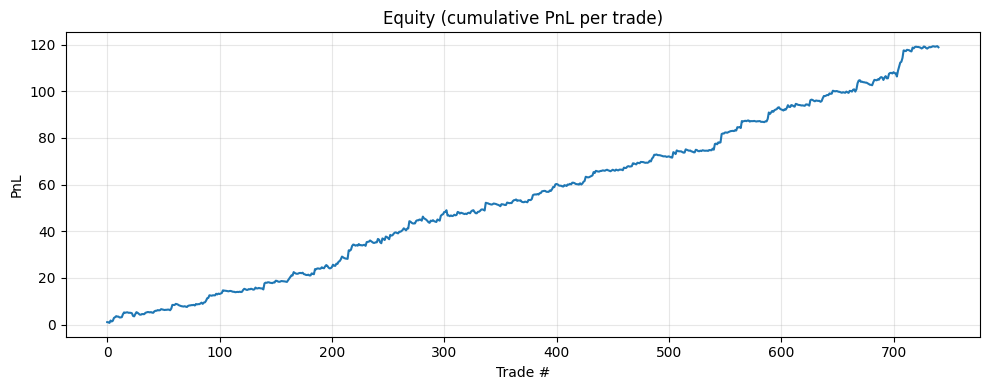

In [10]:
stats, equity, dd = trade_stats(test_df, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()